# Obligatorisk 1 – California housing prices
Notebooken vil følge disse 8 stegene: 
1.	Frame the problem and look av the big picture
2.	Get the data
3.	Explore the data to gain insights
4.	Prepare the data to better expose the underlying data patterns to machine learning algorithms
5.	Explore many different models and short-list the best ones
6.	Fine-tune your models and combine them into a great solution
7.	Present your solution
8.	Launch, monitor and maintain your system


## Frame the problem
Denne oppgaven går ut på å predikere hus-priser i California fra et gitt datasett. 


In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dat158-2020/housing_data.csv
/kaggle/input/dat158-2020/housing_test_data.csv
/kaggle/input/dat158-2020/sample_submission.csv


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('../input/dat158-2020/housing_data.csv')
test = pd.read_csv('../input/dat158-2020/housing_test_data.csv')
sample_submission = pd.read_csv('../input/dat158-2020/sample_submission.csv')

## Utforske data
Head gir oss informasjon om de ulike kolonnene med beskrivende navn. Vi ser at treningssettet har kolonner for blant annet lengde- og breddegrader og totalt antall rom. Hver rad representerer et område.
I describe ser vi at antall forekomster av total_bedrooms er lave (16344) enn resten av verdiene i kolonnene (16512). Dette betyr at vi har verdier som ikke er flyttall i enkelte av total_bedroom-kolonnene. Det kan tenkes at det for eksempel er studioleligheter uten soverom. 
 I tillegg ser vi at verdiene i mean og standardavvik er forskjellige -> vi må finne en bedre måte å jobbe med hele datasettet på. 


In [4]:
train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.13,37.67,40.0,1748.0,318.0,914.0,317.0,3.8676,184000.0,NEAR BAY
1,-120.98,37.65,40.0,422.0,63.0,158.0,63.0,7.3841,172200.0,INLAND
2,-118.37,33.87,23.0,1829.0,331.0,891.0,356.0,6.5755,359900.0,<1H OCEAN
3,-117.89,33.90,23.0,1533.0,226.0,693.0,230.0,7.8980,258200.0,<1H OCEAN
4,-122.40,37.76,52.0,1529.0,385.0,1347.0,348.0,2.9312,239100.0,NEAR BAY
5,-118.10,33.90,40.0,1880.0,377.0,1229.0,378.0,4.4167,174600.0,<1H OCEAN
6,-119.45,36.16,27.0,2119.0,373.0,1268.0,345.0,2.8152,106900.0,INLAND
7,-122.31,38.30,45.0,3023.0,659.0,1789.0,657.0,3.6039,126000.0,NEAR BAY
8,-121.45,38.48,28.0,2780.0,510.0,1638.0,533.0,2.9571,103100.0,INLAND
9,-118.96,35.37,41.0,1463.0,339.0,1066.0,318.0,1.7467,52400.0,INLAND


In [5]:
train.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16344.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.568763,35.630270,28.714571,2636.885841,537.999755,1425.131783,499.837936,3.871083,207262.390080
std,2.003747,2.137134,12.589203,2195.840228,422.944167,1126.453504,383.400473,1.909994,115838.329585
min,-124.350000,32.540000,1.000000,6.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.000000,295.000000,787.000000,279.000000,2.562500,120000.000000
50%,-118.490000,34.260000,29.000000,2122.500000,434.000000,1163.000000,409.000000,3.529450,180400.000000
75%,-118.010000,37.710000,37.000000,3137.000000,646.000000,1723.000000,603.000000,4.746450,265100.000000
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


### Plotte histogrammer for hver kolonne
Vi plotter histogrammer med matplotlib for å få en grafisk presentasjon av verdiene for hver av de 9 kolonnene i treningssettet. Her ser vi at blant annet medianinntekt, husstander, totalt antall rom og totalt antall soverom er såkalt baktunge (tailheavy): verdiene er ikke jevnt spredd utover. 


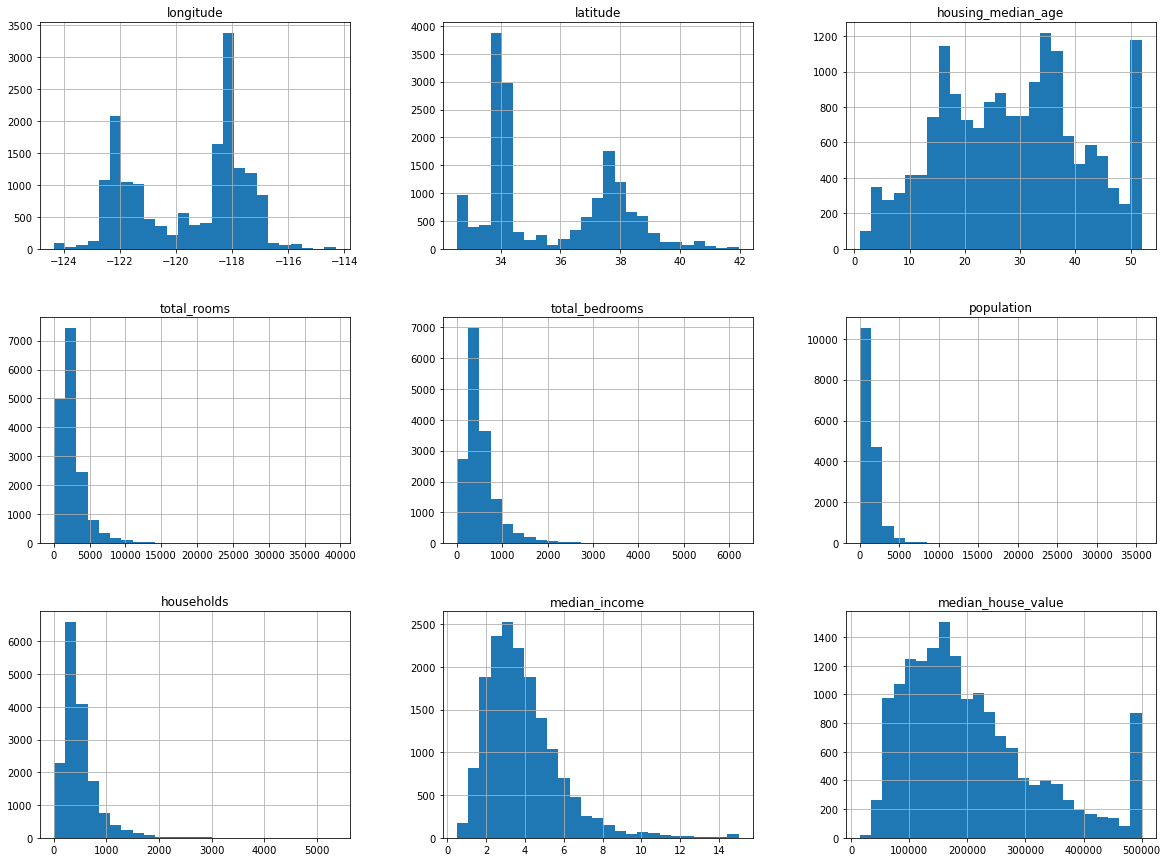

In [6]:
train.hist(bins=25, figsize=(20,15))
plt.show()

### Korrelasjon i heatmap
Vi bruker et heatmap til å se på korrelasjonen mellom de forskjellige verdiene. Velger å fokusere på median husverdi


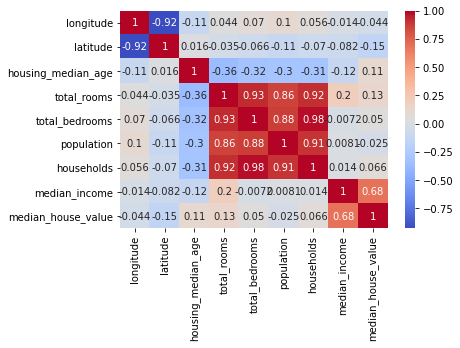

In [7]:
import seaborn as sns
sns.heatmap(train.corr(), annot=True, fmt='.2g', cmap='coolwarm')

Vi ser at median-inntekt og median husverdi har sterk positiv korrelasjon: når inntenkten er høy, er også husverdien det. Vi ser også en negativ korrelasjon mellom breddegrad og verdi, det virker som jo lengre øst (høyere verdi i breddegrad), jo lavere verdi. Dette gir mening fordi California ligger på vestkysten, og dermed er nærmere sjøen jo «lavere» breddegrad. 

Lager et test-sett fra medianinntekt. Bruker Stratisfied shuffle split. 

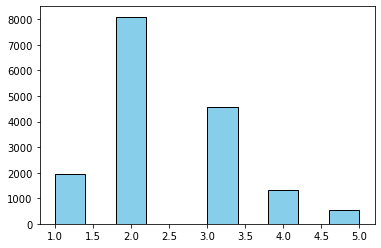

In [8]:
train['income_cat'] = pd.cut(train['median_income'], bins=[0,2,4,6,8,np.inf], labels=[1,2,3,4,5])
train['income_cat'].hist(color='skyblue', ec='black', grid=False)
plt.show()

Vi splitter dataen opp i treningssett og testsett. Treningssettet brukes for å trene modeller, mens testsettet skal brukes når predict() kalles på modellen. I ettertid fant vi ut at det ikke hadde vært nødvendig å splitte opp i flere sett, ettersom oppgaven også kommer med testdata.

In [9]:
# Provides train/test indices to split data in train/test sets.
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(random_state=42, n_splits=1, test_size=0.2)
for train_index, test_index in sss.split(train, train['income_cat']):
    strat_train_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

2    0.490766
3    0.276415
1    0.118377
4    0.081138
5    0.033303
Name: income_cat, dtype: float64

In [10]:
compare_props = pd.DataFrame({
    'Overall': train['income_cat'].value_counts() / len(train),
    'Stratified': strat_test_set['income_cat'].value_counts() / len(strat_test_set)
}).sort_index()
compare_props['Stratified % error'] = 100 * compare_props['Stratified'] / compare_props['Overall'] - 100
compare_props

,Overall,Stratified,Stratified % error
1,0.118217,0.118377,0.135495
2,0.490855,0.490766,-0.018165
3,0.276526,0.276415,-0.040062
4,0.081093,0.081138,0.056504
5,0.033309,0.033303,-0.018165


### Tolkning av median inntekt
Ser at de fleste verdiene ligger mellom 2 og 2,5: cirka 0,49


In [11]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

## Skritt 3: Visualisering av data
Målet med denne delen er å bli mer kjent med dataen, ved å visualisere på ulike måter.

Oppsett for seaborn:

In [12]:
import matplotlib as mpl
sns.set(rc={'figure.figsize':(10,10), 'axes.facecolor':'white'})

Grafen under viser hvor hver bolig er lokalisert, basert på latitude og longitude. Lys grønn indikerer en lavere median_house_value, mens mørkere grønn indikerer en høyere median_house_value. Grafen viser at store deler av boligene i datasettet befinner seg langs kysten av California. Den blå linjen er regresjonslinjen for grafen.

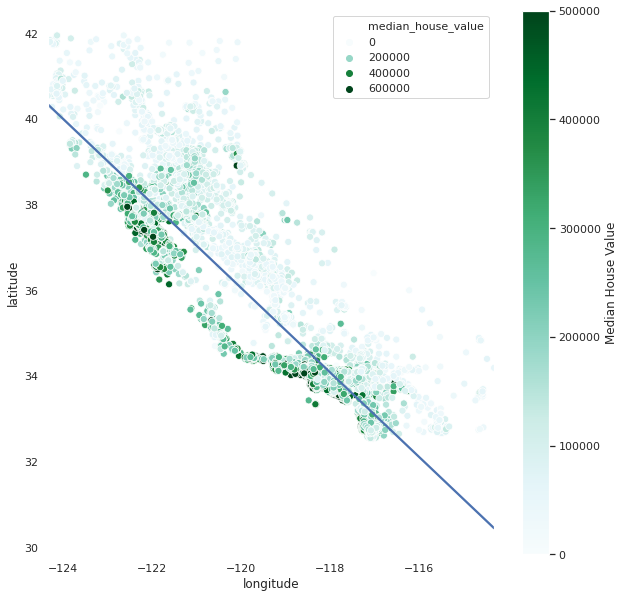

In [13]:
sns.scatterplot(train['longitude'], train['latitude'], hue=train['median_house_value'], s=50, palette='BuGn')
regplot = sns.regplot(data=train, x='longitude', y='latitude', scatter=False)
regplot.figure.colorbar(plt.cm.ScalarMappable
                        (norm = mpl.colors.Normalize
                         (vmin=0, vmax=train['median_house_value'].max(), clip=False), cmap='BuGn'),label='Median House Value')

Denne grafen viser gjennomsnittlig boligpris basert på avstand til havet. Den store 'boksen' i hver kolonne viser øvre og nedre kvartil, og streken i boksen viser gjennomsnitt. Ut fra grafen kan man se at boliger innenlands har mye lavere gjennomsnittspris, men har også større variasjon. Boliger på øyene har mye høyere gjennomsnittspris, men er også lite representert i datasettet.

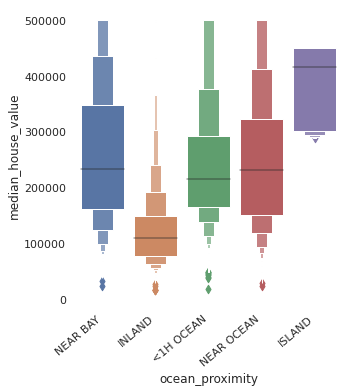

In [14]:
ax = sns.catplot(x='ocean_proximity', y='median_house_value', kind='boxen', data=train)
for axes in ax.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=40, horizontalalignment='right')

**Let's also take a look at the housing age, and see if there's a difference in the median house value:**

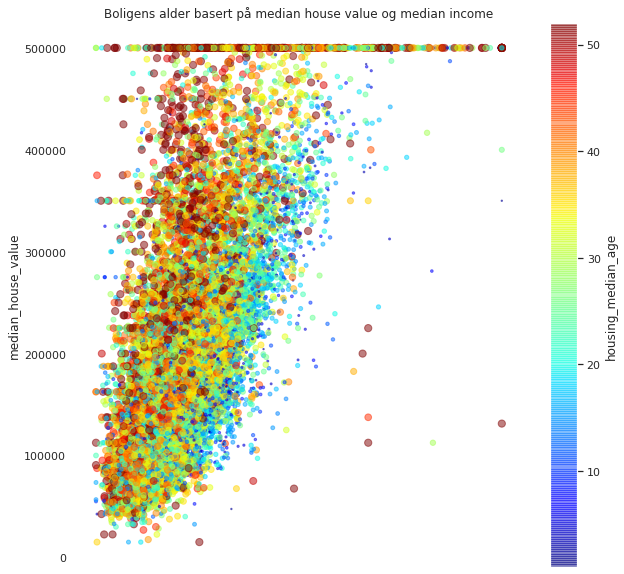

In [15]:
# xlabel vises ikke.
train.plot(kind='scatter', y='median_house_value', x='median_income', 
           s='housing_median_age', 
           title='Boligens alder basert på median house value og median income', 
           figsize=(10,10), alpha=0.5, c='housing_median_age', cmap=plt.get_cmap('jet'), colorbar=True)

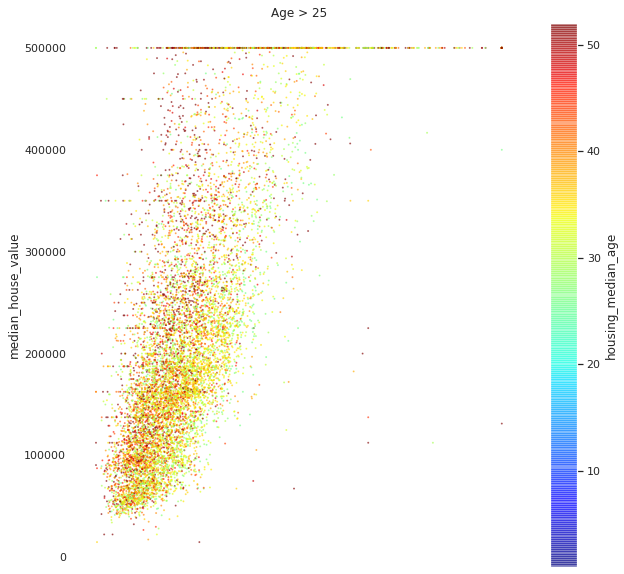

In [16]:
train.plot(kind='scatter', x='median_income', y='median_house_value', 
           s=train['housing_median_age'] > 25, title='Age > 25', figsize=(10,10), alpha=0.5, 
           c='housing_median_age', cmap=plt.get_cmap('jet'), colorbar=True)


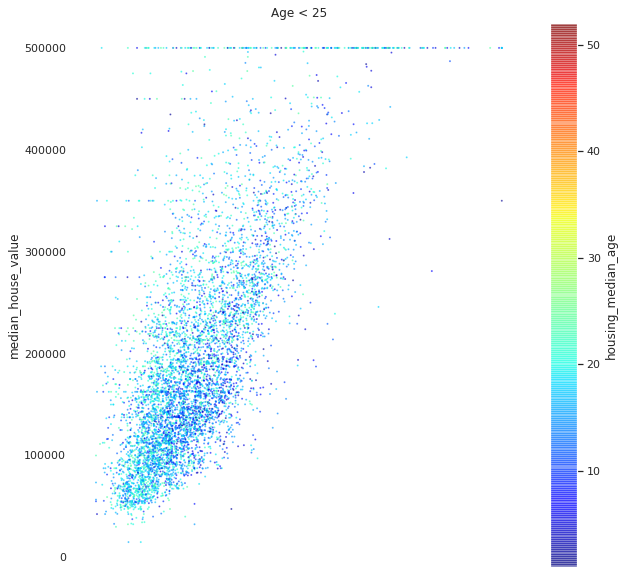

In [17]:
train.plot(kind='scatter', x='median_income', y='median_house_value', 
           s=train['housing_median_age'] < 25, title='Age < 25', 
           figsize=(10,10), alpha=0.5, c='housing_median_age', 
           cmap=plt.get_cmap('jet'), colorbar=True)

Forskjellen mellom hus under og over 25 år er sett under ett ganske liten. Man kan dermed anta at boligens alder har liten påvirkning på median house value.

## Skritt 4: Klargjøre datasettet:

In [18]:
corr_matrix = train.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.684828
total_rooms           0.133566
housing_median_age    0.107684
households            0.065778
total_bedrooms        0.049941
population           -0.025008
longitude            -0.043824
latitude             -0.146748
Name: median_house_value, dtype: float64

Felter med manglende verdier må enten taes bort eller bli fylt med en verdi. Vi bruker SimpleImputer fra sklearn, og fyller de tomme feltene med medianverdien fra tilsvarende kolonne.

In [19]:
#train = the whole dataset except the column 'median_house_value'.
train_set = strat_train_set.drop('median_house_value', axis=1)
#Copies the column 'median_house_value' into train_labels.
train_labels = strat_train_set['median_house_value'].copy()

In [20]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13209 entries, 15727 to 8704
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           13209 non-null  float64
 1   latitude            13209 non-null  float64
 2   housing_median_age  13209 non-null  float64
 3   total_rooms         13209 non-null  float64
 4   total_bedrooms      13081 non-null  float64
 5   population          13209 non-null  float64
 6   households          13209 non-null  float64
 7   median_income       13209 non-null  float64
 8   ocean_proximity     13209 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.0+ MB


Ser fra info at det mangler noen verdier i total_bedrooms. Fyller inn disse:

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
train_num = train_set.drop('ocean_proximity', axis=1)
imputer.fit(train_num)

#Median for all columns except ocean_prox.
imputer.statistics_

array([-118.49  ,   34.26  ,   29.    , 2126.    ,  435.    , 1163.    ,
        410.    ,    3.5331])

Legger den nye dataen inn i en dataframe og sjekker lengden: 13208, ok

In [22]:
X = imputer.transform(train_num)
train_tr = pd.DataFrame( X,  columns=train_num.columns)
train_tr['total_bedrooms'].count

<bound method Series.count of 0         819.0
1         445.0
2         458.0
3         292.0
4         218.0
          ...  
13204     343.0
13205     665.0
13206     285.0
13207    1286.0
13208     471.0
Name: total_bedrooms, Length: 13209, dtype: float64>

### Gjøre om ocean_proximity til tallverdier
Alle andre kolonner har tall som verdi: alle må ha tall for å kunne avgjøre hver attributt/kolonne: bruker OneHotEncoder fra sklearn, som erstatter en kolonne med 5 kolonner (antall forskjellige verdier fra før), hvor man setter 1 i det som er sant (for eksempel 1,0,0,0,0). Dette istedenfor tall. Fordi: tallene tolkes som verdier der 3 er lavere enn 5 osv. mens OneHot tolkes som likeverdige. Dette er bare en demonstrasjon.


In [23]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder()
ocean_cat_encoded = onehot_encoder.fit_transform(train_set[['ocean_proximity']])
ocean_cat_encoded.toarray()

array([[0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

StandardScaler skalerer alle verdier i datasett ved å ta verdien, trekke fra kolonnens gjennomsnitt og deretter dele på standardvariansen. Putter deretter denne og SimpleImputer i en Pipeline.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])
train_tr = num_pipeline.fit_transform(train_num)

Kopierer Id-kolonnen over i nytt objekt som skal brukes til slutt.

In [26]:
test_id = test['Id'].copy()
test.drop('Id', axis=1, inplace=True)

Her transformeres kolonnen 'ocean_proximity' ved bruk av OnehotEncoder. Til slutt dannes det en ny matrise ved bruk av fit_transform på 'full_pipeline'.

In [27]:
from sklearn.compose import ColumnTransformer

num_attr = list(train_num)
cat_attr = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attr),
    ('cat', OneHotEncoder(), cat_attr)
])
train_prepared = full_pipeline.fit_transform(train_set)
submission = full_pipeline.transform(test)

## Skritt 5: Utforsk forskjellige modeller og vis hvilken som er best:

Vi har valgt 4 forskjellig modeller, som testes på treningsdata. Deretter regner vi ut 'root mean square error', hvor en lavere score sannsynligvis indikerer at modellen er god. 

In [28]:
#Predicting using linear regression.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)
train_pred = lin_reg.predict(train_prepared)
lin_mse = mean_squared_error(train_labels, train_pred)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

69351.10734858284


RMSE for LinearRegression er på ca. 69000, som ikke er så veldig bra. Neste modell er RandomForestRegressor:

In [29]:
from sklearn.ensemble import RandomForestRegressor
for_reg = RandomForestRegressor(random_state=42)
for_reg.fit(train_prepared, train_labels)
train_pred1 = for_reg.predict(train_prepared)
lin_rmse1 = np.sqrt(mean_squared_error(train_labels, train_pred1))
print(lin_rmse1)

18777.413858504122


RMSE for RandomForest ser bedre ut, neste modell er LinearSVR:

In [30]:
from sklearn.svm import LinearSVR
svm_reg = LinearSVR(epsilon=1.5)
svm_reg.fit(train_prepared, train_labels)
train_pred2 = svm_reg.predict(train_prepared)
svr_mse = mean_squared_error(train_labels, train_pred2)
print(np.sqrt(svr_mse))

222488.55975032438


Denne forkaster vi, siste modell er LightGBMRegressor:

In [31]:
import lightgbm as lgb
lgb_reg = lgb.LGBMRegressor()
lgb_reg.fit(train_prepared, train_labels, eval_metric='rmse', verbose=2000)
train_pred3 = lgb_reg.predict(train_prepared)
lgb_mse = mean_squared_error(train_labels, train_pred3)
print(np.sqrt(lgb_mse))

40512.90929482555


RMSE for LightGBMRegressor og RandomForestRegressor er de beste av alle modellene vi testet. Vi bruker LightGBMRegressor for videre optimalisering i steg 6.

## Optimalisering av modellen:

Lager en pipeline for beste: bruker grid-search fra sklearn, trener denne på det forberedte testsettet og merkingen (labels). Bruker grid til å finne beste modell. Bruker predict på denne. 

SelectKBest velger 'features' fra den k-høyeste scoren. f_regression er en scoringsfunksjon for å velge beste 'features' fra datasettet. Denne puttes sammen med LGBMRegressor i en Pipeline. Grunnen til dette er at man da har muligheten til å teste ut forskjellige parametre for å se hvilke som passer best for modellen.

In [32]:
from sklearn.feature_selection import SelectKBest, f_regression

pipeline_reg = Pipeline([
    ('selector', SelectKBest(f_regression)),
    ('model', lgb.LGBMRegressor())
])

Vi bruker GridSearch for å kryssvalidere over datasettet basert på parametre.

In [33]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator = pipeline_reg,
    param_grid = {'selector__k':[12], 'model__n_estimators':np.arange(494,495,1),
                  'model__max_bin':[1000]},
    cv=100,
    verbose=3,
    scoring='neg_mean_squared_error', 
    return_train_score=True
)
grid_search.fit(train_prepared, train_labels)

Fitting 100 folds for each of 1 candidates, totalling 100 fits
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-627883139.404, test=-1392740126.916), total=   2.2s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s


[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-621861040.443, test=-2018947697.165), total=   2.0s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s


[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-637063651.772, test=-2288208761.098), total=   2.2s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....
[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-635337121.862, test=-2496426167.661), total=   1.9s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....
[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-625509264.975, test=-2868708672.030), total=   1.9s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....
[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-624113973.146, test=-2403373464.346), total=   1.9s
[CV] model__max_bin=1000, model__n_estimators=494, selector__k=12 ....
[CV]  model__max_bin=1000, model__n_estimators=494, selector__k=12, score=(train=-630967643.340, test=-2135189710.423), total=   1.9s
[CV] model__max_bin=1000, model__n_estimators=

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.9min finished


GridSearchCV(cv=100,
             estimator=Pipeline(steps=[('selector',
                                        SelectKBest(score_func=<function f_regression at 0x7f68e34e6d40>)),
                                       ('model', LGBMRegressor())]),
             param_grid={'model__max_bin': [1000],
                         'model__n_estimators': array([494]),
                         'selector__k': [12]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

'cvres' skriver ut en tabell med resultater, hvor lavere er bedre.

In [34]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


46146.808729138174 {'model__max_bin': 1000, 'model__n_estimators': 494, 'selector__k': 12}


Skriver ut den beste kombinasjonen av parametre. Den beste scoren som ble oppnådd er 46146. Etter mye testing kom vi frem til at parametrene k = 12, n_estimators = 494 og max_bin = 1000 gir de beste resultatene dersom cv=100. Det kan argumenteres for at tidskostnaden ved å sette cv=100 er større enn gevinsten, som er en svakt forbedret modell, og at dette dermed ikke er nødvendig.

In [35]:
print(grid_search.best_params_)

{'model__max_bin': 1000, 'model__n_estimators': 494, 'selector__k': 12}


Setter 'final_model' til den beste estimatoren fra 'grid_search', deretter kjører man predict() på submission.

In [36]:
final_model = grid_search.best_estimator_
final_predict = final_model.predict(submission)

In [37]:

output = pd.DataFrame({
    'Id': test_id,
    'median_house_value': final_predict
})
output.head(10)

,Id,median_house_value
0,0,256282.814613
1,1,283220.764291
2,2,77251.202709
3,3,143372.755954
4,4,58387.884469
5,5,167693.537480
6,6,88083.785667
7,7,108220.960344
8,8,143397.983175
9,9,68023.928269


In [38]:
output.to_csv('submission.csv', index=False)

## Skritt 7: Presenter løsningen og arbeidsmetoder

I dette prosjektet har vi lært at 'median_house_value' blir mest påvirket av 'median_income'. Vi har også lært at antakelsen om at boligens alder påvirket pris var feil, og at boligens alder hadde veldig lite å si for 'median_house_value'. Vi ble også kjent med forskjellene i 'median_house_value' basert på avstand til havet, 'ocean_proximity', og at mellom kategoriene var det vesentlige forskjeller.

I ettertid fant vi ut at det ikke er nødvendig å splitte opp i trenings- og testsett ved bruk av StratifiedShuffleSplit, og at dette faktisk kan være en ulempe, ettersom det opprinnelige treningssettet har mer data enn 'strat_train_set'.

Vi brukte relativt lite tid på rengjøring av data, og det kunne vært interessant å se om modellen hadde blitt bedre dersom vi hadde rengjort datasettet på andre måter, f.eks. ved å sette manglende verdier til 0, normalisert verdiene istedenfor å standardisere osv.

Valg av modell ble basert på RMSE og kryssvalideringsscore ved bruk av GridSearch. LGBMRegressor har ganske mange forskjellige parametre som kan settes, så det fins muligheter for at RandomizedSearch kunne gitt bedre resultater. Selve modellfittingen tok "lang" tid, i den forstand at Kaggle bare tillater å kjøre én jobb om gangen. Den beste estimatoren ga scoren 46146, med parametre k = 12 for SelectKBest, n_estimators = 494 og max_bin = 1000 for LGBMRegressor, og cv=100.

Alt i alt har det vært veldig lærerikt for samtlige i gruppen!

**Sources:**

https://medium.com/@411.codebrain/train-test-split-vs-stratifiedshufflesplit-374c3dbdcc36

https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html